# Finding fiducial magnitudes for $t_{\mbox{eff}}$

## Introduction

$t_{\mbox{eff}}$ is a measure of depth, related to limiting magnitude as:

\begin{align}
t_{\mbox{eff}} & = 10^{\frac{4}{5}(m_\circ - m_{\mbox{lim}})} \\
m_{\mbox{lim}} & = m_\circ + 1.25 \log t_{\mbox{eff}}
\end{align}

such limiting magnitude varies with $t_{\mbox{eff}}$ in the same way as it varies with exposure time.

The constant $m_\circ$ provides a reference point, defining at what magnitude $t_{\mbox{eff}} = 1$, analogous to the constant reference magnitude in the definition of a magnitude system: accumulated $t_{\mbox{eff}}$ represents the progress made toward reaching a target coadd limiting magnitude, as measured in exposure time under constant conditions. If $m_\circ$ is the typical limiting magnitude for the instrument under real conditions, the difference between the accumulated $t_{\mbox{eff}}$ and the $t_{\mbox{eff}}$ corresponding to the target limiting magnitude is a good approximation of the total exposure time needed to attain the target limiting magnitude. If $m_\circ$ is different from that typical for the instrument, then the remaining $t_{\mbox{eff}}$ will be related to the remaining needed exposure time by a scaling factor. 

A reasonable fiducial magnitude for a given instrument is to define for $t_{\mbox{eff}}=1$ for optimally pointing images under typical conditions: taken at zenith, during dark time, in typical seeing. With this fiducial magnitude, the remaining needed $t_{\mbox{eff}}$ matches the remaining exposure time if optimally scheduled, and the target limiting magnitude varies with the zenith distance at transit.

`opsim` provides a function, `m5_flat_sed`, to calculate the limiting magnitude (including various throughputs, etc.) under a given set of conditions (seeing, airmass, and sky brightness) using parameters provided by system engineering.

The initial section of this notebook uses the mean log Fried parameter (according to the model described in RTN-022) to deteremine the seeing, the sky brightness model used by `opsim` in full dark conditions, zenith pointing (airmass=1), and `m5_flat_sed` to compute fiducial zero points for $t_{\mbox{eff}}$.

The later section of the notebook generates magnitude using different assumptions about the throughput, seeing, sky brightness, and airmass to trace the differences between magnitudes derived from the SRD and estimates based on the latest assumptions used by `opsim`.

For discussion related to this notebook and the resoning behind it, see the conversations in the `survey-strategy-team` LSSTC slack channel starting April 9, 2021 (around [here](https://lsstc.slack.com/archives/G6MP1HTDW/p1617997908069200)), through April 20th.

## Notebook setup

### Logging

Do it first so I can use logging to track how long imports take.

In [1]:
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logger.info("Starting")

2021-07-07 10:16:50,980 Starting


### Imports

In [2]:
import os
import os.path
import copy
import pickle
import urllib
from os import path
from tempfile import TemporaryDirectory

In [3]:
logger.debug("Loading common modules")
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3

2021-07-07 10:16:51,019 Loading common modules


In [4]:
logger.debug("Loading general astronomy modules")
import healpy
import palpy
import astropy
import astropy.coordinates
from astropy.coordinates import EarthLocation
from astropy.time import Time
import astropy.units as u

2021-07-07 10:16:51,465 Loading general astronomy modules


In [5]:
logger.debug("Loading Rubin Observatory modules")
import rubin_sim
import rubin_sim.site_models
from rubin_sim.utils import m5_flat_sed
from rubin_sim.site_models import SeeingData, SeeingModel
from rubin_sim.site_models import CloudData
from rubin_sim.skybrightness_pre import SkyModelPre

2021-07-07 10:16:51,843 Loading Rubin Observatory modules


### Plot setup

In [6]:
mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)

### Constants

In [7]:
sky_model = SkyModelPre()
site = EarthLocation.of_site('Cerro Pachon')
mean_log_r0 = -0.9163 ;# See RTN-022, table 1
mjd_sample_rate = 0.01 ;# Every 0.01 days = every 14.4 minutes
original_median_seeing500 = 0.62
data_dir = '.'
opsim_origin = 'https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.7/baseline/baseline_nexp2_v1.7_10yrs.db'

In [8]:
bands = pd.DataFrame({
    'band': ('u', 'g', 'r', 'i', 'z', 'y'),
    'min_wavelength': (350.0, 400.0, 552.0, 691.0, 818.0, 949.0),
    'max_wavelength': (400.0, 552.0, 691.2, 818.0, 922.0, 1060.0)}
).set_index('band', drop=False)
bands

,band,min_wavelength,max_wavelength
band,,,
u,u,350.0,400.0
g,g,400.0,552.0
r,r,552.0,691.2
i,i,691.0,818.0
z,z,818.0,922.0
y,y,949.0,1060.0


In [9]:
sun_cache_fname = 'sun_cache.pickle'
moon_cache_fname = 'moon_cache.pickle'
sky_cache_fname = 'sky_cache.pickle'
sky_x12_cache_fname = 'sky_x12_cache.pickle'
visit_cache = 'opsim_visits.h5'

### Retrieving data

In [10]:
if path.isfile(opsim_origin) or 'opsim_fname' in locals():
    # Check for opsim_fname in locals so that if we rerun the notebook without restarting the kernel
    # it will not re-download the data
    opsim_fname = opsim_origin
else:
    opsim_data_dir = TemporaryDirectory(dir=data_dir)
    opsim_fname = path.join(opsim_data_dir.name, opsim_origin.split('/')[-1])
    logger.info("Downloading %s to %s", opsim_origin, opsim_fname)
    opsim_db_file = urllib.request.urlretrieve(opsim_origin, opsim_fname)
    logger.info("Download complete")
    
    print(f"Opsim data file downloaded to\n\t{opsim_fname}\nwhich will be deleted when the notebook is restarted or closed.")

2021-07-07 10:16:52,167 Downloading https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.7/baseline/baseline_nexp2_v1.7_10yrs.db to ./tmpuuwbabty/baseline_nexp2_v1.7_10yrs.db
2021-07-07 10:16:56,117 Download complete


Opsim data file downloaded to
	./tmpuuwbabty/baseline_nexp2_v1.7_10yrs.db
which will be deleted when the notebook is restarted or closed.


In [11]:
opsim_name = os.path.splitext(os.path.split(opsim_fname)[-1])[0]

### Configuration

In [12]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Seeing

The seeing model of RTN-022 provides a mean log r0 (Fried parameter), which provides an average seeing. Begin by transforming that to a von Karman seeing with an outer scale of 30m:

In [13]:
def vk_seeing(r0, outer_scale=30.0, wavelength=5.0e-7):
    """Calculate the seeing using a von Karman model.

    See Tokovinin 2002PASP..114.1156T

    Args:
        r0: the Fried parameter, in meters
        outer_scale: the von Karman outer scale, in meters
        wavelength: the wavelength of light, in meters

    Returns:
        The PSF FWHM, in arcseconds
    """
    # Calculate the DIMM estimate of the seeing using the Kolmogorov model,
    # using eqn 5 from Tokovinin 2002PASP..114.1156T eqn 5
    kol_seeing = 0.98*wavelength/r0

    # Calculate the correction factor required to convert the Kolmogorov model
    # seeing to the von Karman model seeing,
    # using eqn 19 of Tokovinin 2002PASP..114.1156T
    vk_correction2 = 1.0 - 2.183*np.power(r0/outer_scale, 0.356)

    # Apply the correction factor
    seeing_rad = kol_seeing * np.sqrt(vk_correction2)

    # Convert to arcseconds
    seeing = np.degrees(seeing_rad)*(60.0*60.0)

    return seeing

seeing500 = np.round(vk_seeing(10**mean_log_r0, outer_scale=30), 2)
seeing500

0.69

Now, apply the `opsim` seeing model:

In [14]:
seeing_model = SeeingModel()
seeing = pd.Series(seeing_model(seeing500, 1.0)['fwhmEff'], index=bands.band)
seeing

band
u   1.01
g   0.95
r   0.89
i   0.86
z   0.83
y   0.81
dtype: float64

## Sky

Sample the sky at intervals for all dark time in the survey:

In [15]:
%%time
mjd_range = (astropy.time.Time('2022-10-01T16:00:00Z').mjd, astropy.time.Time('2032-10-01T16:00:00Z').mjd)
all_mjds = np.arange(*mjd_range, mjd_sample_rate)
all_times = astropy.time.Time(all_mjds, scale='utc', format='mjd', location=site)

try:
    with open(sun_cache_fname, 'rb') as sun_cache:
        sun_coords = pickle.load(sun_cache)
    with open(moon_cache_fname, 'rb') as moon_cache:
        moon_coords = pickle.load(moon_cache)
except FileNotFoundError:
    sun_coords = astropy.coordinates.get_sun(all_times).transform_to(astropy.coordinates.AltAz(obstime=all_times, location=site))
    with open(sun_cache_fname, 'wb') as fp:
        pickle.dump(sun_coords, fp)

    moon_coords = astropy.coordinates.get_moon(all_times).transform_to(astropy.coordinates.AltAz(obstime=all_times, location=site))
    with open(moon_cache_fname, 'wb') as moon_cache:
        pickle.dump(moon_coords, moon_cache)

dark_idxs = np.logical_and(sun_coords.alt.deg < -18, moon_coords.alt.deg < -18)
mjds = all_mjds[dark_idxs]
times = all_times[dark_idxs]

/data/des91.b/data/neilsen/anaconda/envs/rubin_sim/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


CPU times: user 39.9 ms, sys: 72.9 ms, total: 113 ms
Wall time: 115 ms


Find the healpixels for the standard pointing (zenith) for the sampled times:

In [16]:
def find_zenith_hpixs(mjd, site, nside, north=True):
    lst = Time(mjd, format='mjd', location=site).sidereal_time('apparent').to_value(u.degree)
    ra = lst
    decl = site.lat.deg
    hpix = healpy.ang2pix(nside, ra, decl, lonlat=True)
    return hpix

Actually calculate the sky brightnesses:

/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


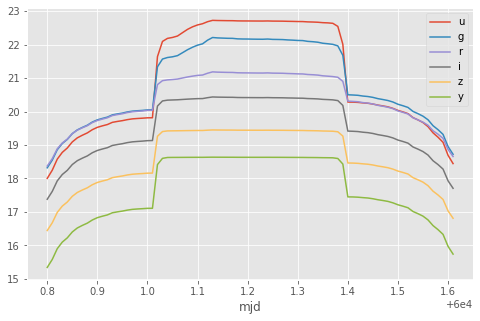

In [17]:
def compute_zenith_mags(mjds, sky_model, **kwargs):
    zenith_hpixs = pd.DataFrame({'mjd': mjds,
                                 'hpix': find_zenith_hpixs(mjds, **kwargs)})
    mags = zenith_hpixs.apply(
        lambda x: pd.Series({k: m[0] for k, m in sky_model.returnMags(x.mjd, indx=np.array([x.hpix], dtype=int), badval=np.nan, zenith_mask=False).items()}),
        axis=1)
    mags['mjd'] = mjds
    return mags
    
if __debug__:
    df = compute_zenith_mags(np.arange(60000.7, 60001.7, 0.01), sky_model, site=site, nside=sky_model.nside)
    ax = None
    for band in bands.band:
        ax = df.plot('mjd', band, ax=ax)

In [18]:
%%time
try:
    with open(sky_cache_fname, 'rb') as sky_cache:
        dark_sky_mags = pickle.load(sky_cache)
except FileNotFoundError:
    dark_sky_mags = compute_zenith_mags(mjds, sky_model=sky_model, site=site, nside=sky_model.nside)
    with open(sky_cache_fname, 'wb') as sky_cache:
        pickle.dump(dark_sky_mags, sky_cache)

CPU times: user 2.16 ms, sys: 5.29 ms, total: 7.45 ms
Wall time: 7.23 ms


Get the median dark sky in each band:

In [19]:
median_dark_sky = dark_sky_mags.median()
median_dark_sky

u        22.68
g        22.11
r        21.11
i        20.39
z        19.43
y        18.63
mjd   61710.15
dtype: float64

## Calculate the fiducial magnitudes

In [20]:
try:
    # Make sure we are using parameters as defined in the code. 
    delattr(m5_flat_sed, 'Cm')
except AttributeError:
    pass

m0 = bands.copy()
m0.apply(
        lambda r: m5_flat_sed(r['band'], median_dark_sky[r['band']], seeing[r['band']], expTime=15, airmass=1, nexp=2), axis=1).round(2)

band
u   23.71
g   24.67
r   24.24
i   23.82
z   23.21
y   22.40
dtype: float64

# Tracing the origin of differences with the SRD

## SRD m5

Copy values from the SRD:

In [21]:
m5 = pd.DataFrame(
    {'SRD spec': [23.9, 25.0, 24.7, 24.0, 23.3, 22.1],
     'SRD min': [23.4 ,24.6, 24.3, 23.6, 22.9, 21.7],
     'SRD stretch': [24.0, 25.1, 24.8, 24.1, 23.4, 22.2]},
    index=bands.band)

## Reproduce m5 from the overview paper

Table 2 from p. 26 of the [overview paper](https://arxiv.org/abs/0805.2366).

In [22]:
overview_table2 = pd.DataFrame({'m_sky': [22.99, 22.26, 21.20, 20.48, 19.60, 18.61],
                                'theta': [0.81, 0.77, 0.73, 0.71, 0.69, 0.68],
                                'theta_eff': [0.92, 0.87, 0.83, 0.80, 0.79, 0.76],
                                'gamma': [0.038, 0.039, 0.039, 0.039, 0.039, 0.039],
                                'k_m': [0.491, 0.213, 0.126, 0.096, 0.069, 0.170],
                                'C_m': [23.09, 24.42, 24.44, 24.32, 24.16, 23.73],
                                'm5': [23.78, 24.81, 24.35, 23.92, 23.34, 22.45],
                                'Delta_C_m_infinity': [0.62, 0.18, 0.10, 0.07, 0.05, 0.04],
                                'Delta_C_m_2': [0.23, 0.08, 0.05, 0.03, 0.02, 0.02],
                                'Delta_m5': [0.21, 0.16, 0.14, 0.13, 0.13, 0.14],
                               }, index=bands.index)

overview_table2.T

band,u,g,r,i,z,y
m_sky,22.99,22.26,21.20,20.48,19.60,18.61
theta,0.81,0.77,0.73,0.71,0.69,0.68
theta_eff,0.92,0.87,0.83,0.80,0.79,0.76
gamma,0.04,0.04,0.04,0.04,0.04,0.04
k_m,0.49,0.21,0.13,0.10,0.07,0.17
C_m,23.09,24.42,24.44,24.32,24.16,23.73
m5,23.78,24.81,24.35,23.92,23.34,22.45
Delta_C_m_infinity,0.62,0.18,0.10,0.07,0.05,0.04
Delta_C_m_2,0.23,0.08,0.05,0.03,0.02,0.02
Delta_m5,0.21,0.16,0.14,0.13,0.13,0.14


Call `m5_flat_sed` once to instantiate default parameters.

In [23]:
try:
    # Make sure we are using parameters as defined in the code. 
    delattr(m5_flat_sed, 'Cm')
except AttributeError:
    pass

_ = m5_flat_sed('u', 23, 1.0, 30.0, 1.0)

In [24]:
m5_flat_sed.Cm = overview_table2.C_m.to_dict()
m5_flat_sed.dCm_infinity = overview_table2.Delta_C_m_infinity.to_dict()
m5_flat_sed.kAtm = overview_table2.k_m
m5_flat_sed.msky = overview_table2.m_sky

In [25]:
m5['overview'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'], r['m_sky'], r['theta_eff'], expTime=30, airmass=1.0, nexp=1), axis=1).values
m5

,SRD spec,SRD min,SRD stretch,overview
band,,,,
u,23.90,23.40,24.00,23.79
g,25.00,24.60,25.10,24.81
r,24.70,24.30,24.80,24.36
i,24.00,23.60,24.10,23.92
z,23.30,22.90,23.40,23.33
y,22.10,21.70,22.20,22.45


Compare m5 as re-derived from the table using `m5_flat_sed` with the actual values from the table:

In [26]:
m5['overview'] - overview_table2['m5']

band
u    0.01
g    0.00
r    0.01
i   -0.00
z   -0.01
y   -0.00
dtype: float64

Okay, so close, but maybe some rounding difference.

## Move to airmass of 1.2

See if we can reproduce the `theta_eff` from overview table 2 using `SeeingModel`, so we can use it to calculate the effective seeing at other airmasses.

In [27]:
seeing_model = SeeingModel()

In [28]:
test_eff_seeing = pd.DataFrame(
    {'table 2': overview_table2.theta_eff.values,
     'SeeingModel': seeing_model(original_median_seeing500, 1.0)['fwhmEff']},
index=bands.index)
test_eff_seeing['difference'] = test_eff_seeing['SeeingModel'] - test_eff_seeing['table 2']
test_eff_seeing

,table 2,SeeingModel,difference
band,,,
u,0.92,0.93,0.01
g,0.87,0.87,0.00
r,0.83,0.83,-0.00
i,0.80,0.80,-0.00
z,0.79,0.77,-0.02
y,0.76,0.76,-0.00


Pre-compute the effective seeing at airmass

In [29]:
original_seeing_12 = pd.Series(seeing_model(original_median_seeing500, 1.2)['fwhmEff'], index=bands.index)
original_seeing_12

band
u   1.03
g   0.98
r   0.92
i   0.89
z   0.86
y   0.85
dtype: float64

In [30]:
m5['airmass'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'], r['m_sky'], original_seeing_12[r['band']], expTime=30, airmass=1.2, nexp=1), axis=1).values
m5

,SRD spec,SRD min,SRD stretch,overview,airmass
band,,,,,
u,23.90,23.40,24.00,23.79,23.56
g,25.00,24.60,25.10,24.81,24.65
r,24.70,24.30,24.80,24.36,24.21
i,24.00,23.60,24.10,23.92,23.78
z,23.30,22.90,23.40,23.33,23.22
y,22.10,21.70,22.20,22.45,22.30


Compare change to airmass 1.2 to that reported in table 2:

In [31]:
test_airmass12 = pd.DataFrame({'table 2 Delta_m5': overview_table2.Delta_m5,
                               'Delta_m5': m5['overview'] - m5['airmass']})
test_airmass12['diff'] = test_airmass12['Delta_m5'] - test_airmass12['table 2 Delta_m5']
test_airmass12

,table 2 Delta_m5,Delta_m5,diff
band,,,
u,0.21,0.23,0.02
g,0.16,0.17,0.01
r,0.14,0.14,0.00
i,0.13,0.13,0.00
z,0.13,0.11,-0.02
y,0.14,0.15,0.01


## Update to use throughput in `sims_utils`

Trigger reinitialzation of the parameters in `m5_flat_sed` to be defaults when called:

In [32]:
del m5_flat_sed.Cm

In [33]:
m5['throughput'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'], r['m_sky'], original_seeing_12[r['band']], expTime=30, airmass=1.2, nexp=1), axis=1).values
m5

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput
band,,,,,,
u,23.90,23.40,24.00,23.79,23.56,23.85
g,25.00,24.60,25.10,24.81,24.65,24.73
r,24.70,24.30,24.80,24.36,24.21,24.26
i,24.00,23.60,24.10,23.92,23.78,23.83
z,23.30,22.90,23.40,23.33,23.22,23.26
y,22.10,21.70,22.20,22.45,22.30,22.34


## Switch to two exposures per visit

In [34]:
m5['2exp'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'], r['m_sky'], original_seeing_12[r['band']], expTime=15, airmass=1.2, nexp=2), axis=1).values
m5

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp
band,,,,,,,
u,23.90,23.40,24.00,23.79,23.56,23.85,23.63
g,25.00,24.60,25.10,24.81,24.65,24.73,24.65
r,24.70,24.30,24.80,24.36,24.21,24.26,24.22
i,24.00,23.60,24.10,23.92,23.78,23.83,23.80
z,23.30,22.90,23.40,23.33,23.22,23.26,23.24
y,22.10,21.70,22.20,22.45,22.30,22.34,22.32


Compare with the difference reported in overview table 2:

In [35]:
pd.DataFrame({'calculated': m5['throughput'] - m5['2exp'],
              'overview': overview_table2['Delta_C_m_2'],
              'diff': overview_table2['Delta_C_m_2'] + m5['2exp'] - m5['throughput']})

,calculated,overview,diff
band,,,
u,0.22,0.23,0.01
g,0.08,0.08,-0.00
r,0.05,0.05,0.00
i,0.03,0.03,-0.00
z,0.02,0.02,-0.00
y,0.02,0.02,0.00


## Change to the latest seeing model

In [36]:
seeing_airmass12 = pd.Series(seeing_model(seeing500, 1.2)['fwhmEff'], index=bands.band)
seeing_airmass12

band
u   1.12
g   1.06
r   1.00
i   0.96
z   0.93
y   0.91
dtype: float64

In [37]:
m5['seeing'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'], r['m_sky'], seeing_airmass12[r['band']], expTime=15, airmass=1.2, nexp=2), axis=1).values
m5

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing
band,,,,,,,,
u,23.90,23.40,24.00,23.79,23.56,23.85,23.63,23.54
g,25.00,24.60,25.10,24.81,24.65,24.73,24.65,24.56
r,24.70,24.30,24.80,24.36,24.21,24.26,24.22,24.13
i,24.00,23.60,24.10,23.92,23.78,23.83,23.80,23.72
z,23.30,22.90,23.40,23.33,23.22,23.26,23.24,23.16
y,22.10,21.70,22.20,22.45,22.30,22.34,22.32,22.24


## Change to the latest sky brightness model and airmass=1.2

In [38]:
night_idxs = sun_coords.alt.deg < -14
night_mjds = all_mjds[night_idxs]
night_times = all_times[night_idxs]

In [39]:
def compute_zd_from_airmass(airmass, a=470.0):
    mu = (1.0/airmass) + (1/(2.0*a))*((1.0/airmass) - airmass)
    zd = np.degrees(np.arccos(mu))
    return zd

if __debug__:
    # Bemporad values (empirical values for airmass as a function of zenith distance)
    assert compute_zd_from_airmass(1)==0
    assert np.round(compute_zd_from_airmass(1.154), 1)==30
    assert np.round(compute_zd_from_airmass(1.995), 1)==60
    assert np.round(compute_zd_from_airmass(2.904), 1)==70
    assert np.round(compute_zd_from_airmass(18.8))==88

In [40]:
def compute_transiting_hpixs(mjd, airmass, site, nside, north=True):
    zd = compute_zd_from_airmass(airmass)
    lst = Time(mjd, format='mjd', location=site).sidereal_time('apparent').to_value(u.degree)
    ra = lst
    decl = site.lat.deg + zd if north else site.lat.degrees - zd
    hpix = healpy.ang2pix(nside, ra, decl, lonlat=True)
    return hpix

Actually calculate the sky brightnesses:

/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


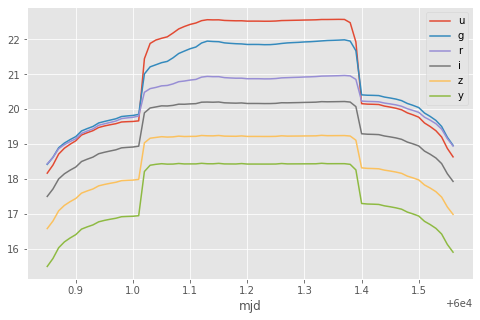

In [41]:
def compute_transiting_mags(mjds, sky_model, **kwargs):
    transiting_hpixs = pd.DataFrame({'mjd': mjds,
                                     'hpix': compute_transiting_hpixs(mjds, **kwargs)})
    mags = transiting_hpixs.apply(
        lambda x: pd.Series({k: m[0] for k, m in sky_model.returnMags(x.mjd, indx=np.array([x.hpix], dtype=int), badval=np.nan, zenith_mask=False).items()}),
        axis=1)
    mags['mjd'] = mjds
    return mags
    
if __debug__:
    df = compute_transiting_mags(np.arange(60000.7, 60001.7, 0.01), sky_model, airmass=1.2, site=site, nside=sky_model.nside)
    ax = None
    for band in bands.band:
        ax = df.plot('mjd', band, ax=ax)

In [42]:
%%time
try:
    with open(sky_x12_cache_fname, 'rb') as sky_cache:
        sky_mags_x12 = pickle.load(sky_cache)
except FileNotFoundError:
    sky_mags_x12 = compute_transiting_mags(night_mjds, sky_model=sky_model, airmass=1.2, site=site, nside=sky_model.nside)
    with open(sky_x12_cache_fname, 'wb') as sky_cache:
        pickle.dump(sky_mags_x12, sky_cache)

CPU times: user 1.1 ms, sys: 6.1 ms, total: 7.2 ms
Wall time: 4.78 ms


In [43]:
sky_x12_mag_stats = sky_mags_x12.describe()
sky_x12_mag_stats

,u,g,r,i,z,y,mjd
count,146227.00,146227.00,146227.00,146227.00,146227.00,146227.00,148164.00
mean,21.32,20.68,20.05,19.61,18.92,18.28,61691.99
std,1.57,1.62,1.20,0.84,0.48,0.26,1054.35
min,17.75,16.93,16.85,17.01,17.08,17.07,59854.00
25%,19.85,19.13,19.04,19.03,18.70,18.19,60788.37
50%,22.45,21.83,20.87,20.16,19.22,18.43,61680.17
75%,22.56,21.96,20.95,20.21,19.25,18.44,62615.11
max,22.61,22.07,21.03,20.26,19.28,18.47,63506.39


The nominal total number of u, g, and r exposures is the same as the nominal total z and y.

If we assume u, g, and r are observed in the darkest 50% of time, the z and y in the brightest, and the i evenly split, then we get:

In [44]:
typical_m_sky = pd.Series([
    sky_x12_mag_stats.loc['75%', 'u'],
    sky_x12_mag_stats.loc['75%', 'g'],
    sky_x12_mag_stats.loc['75%', 'r'],
    sky_x12_mag_stats.loc['50%', 'i'],
    sky_x12_mag_stats.loc['25%', 'z'],
    sky_x12_mag_stats.loc['25%', 'y']],
    index=bands.index
)
typical_m_sky

band
u   22.56
g   21.96
r   20.95
i   20.16
z   18.70
y   18.19
dtype: float64

In [45]:
m5['sky'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'], typical_m_sky[r['band']], seeing_airmass12[r['band']], expTime=15, airmass=1.2, nexp=2), axis=1).values
m5

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky
band,,,,,,,,,
u,23.90,23.40,24.00,23.79,23.56,23.85,23.63,23.54,23.46
g,25.00,24.60,25.10,24.81,24.65,24.73,24.65,24.56,24.45
r,24.70,24.30,24.80,24.36,24.21,24.26,24.22,24.13,24.03
i,24.00,23.60,24.10,23.92,23.78,23.83,23.80,23.72,23.58
z,23.30,22.90,23.40,23.33,23.22,23.26,23.24,23.16,22.74
y,22.10,21.70,22.20,22.45,22.30,22.34,22.32,22.24,22.04


## Baseline median and mean

Look at what a baseline `opsim` simulation actually achieves.

In [46]:
try:
    visits = pd.read_hdf(visit_cache, opsim_name)
except (FileNotFoundError, KeyError):
    with sqlite3.connect(opsim_fname) as con:
        visits = pd.read_sql_query('SELECT * FROM SummaryAllProps', con)
    visits.set_index('filter', drop=False, inplace=True)
    visits.index.name = 'band'
    visits.to_hdf(visit_cache, opsim_name)

In [47]:
m5['b. median'] = visits.groupby('band').agg({'fiveSigmaDepth': 'median'}).loc[bands.index, 'fiveSigmaDepth'].T
m5['b. mean'] = visits.groupby('band').agg({'fiveSigmaDepth': 'mean'}).loc[bands.index, 'fiveSigmaDepth'].T
m5

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky,b. median,b. mean
band,,,,,,,,,,,
u,23.90,23.40,24.00,23.79,23.56,23.85,23.63,23.54,23.46,23.39,23.35
g,25.00,24.60,25.10,24.81,24.65,24.73,24.65,24.56,24.45,24.44,24.40
r,24.70,24.30,24.80,24.36,24.21,24.26,24.22,24.13,24.03,24.00,23.96
i,24.00,23.60,24.10,23.92,23.78,23.83,23.80,23.72,23.58,23.43,23.37
z,23.30,22.90,23.40,23.33,23.22,23.26,23.24,23.16,22.74,22.78,22.74
y,22.10,21.70,22.20,22.45,22.30,22.34,22.32,22.24,22.04,22.00,21.97


## Baseline mag from mean t_eff

In [48]:
def compute_teff(ref_mags, mags=visits.fiveSigmaDepth):
    t_eff = 10**(0.8*(mags-ref_mags.loc[mags.index]))
    return t_eff

In [49]:
m5['b. teff mean'] = m5['SRD spec'] + 1.25*np.log10(compute_teff(m5['SRD spec'], visits.fiveSigmaDepth).groupby('band').mean())
m5

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky,b. median,b. mean,b. teff mean
band,,,,,,,,,,,,
u,23.90,23.40,24.00,23.79,23.56,23.85,23.63,23.54,23.46,23.39,23.35,23.45
g,25.00,24.60,25.10,24.81,24.65,24.73,24.65,24.56,24.45,24.44,24.40,24.50
r,24.70,24.30,24.80,24.36,24.21,24.26,24.22,24.13,24.03,24.00,23.96,24.05
i,24.00,23.60,24.10,23.92,23.78,23.83,23.80,23.72,23.58,23.43,23.37,23.50
z,23.30,22.90,23.40,23.33,23.22,23.26,23.24,23.16,22.74,22.78,22.74,22.84
y,22.10,21.70,22.20,22.45,22.30,22.34,22.32,22.24,22.04,22.00,21.97,22.06


In [50]:
print(m5)

      SRD spec  SRD min  SRD stretch  overview  airmass  throughput  2exp  \
band                                                                        
u        23.90    23.40        24.00     23.79    23.56       23.85 23.63   
g        25.00    24.60        25.10     24.81    24.65       24.73 24.65   
r        24.70    24.30        24.80     24.36    24.21       24.26 24.22   
i        24.00    23.60        24.10     23.92    23.78       23.83 23.80   
z        23.30    22.90        23.40     23.33    23.22       23.26 23.24   
y        22.10    21.70        22.20     22.45    22.30       22.34 22.32   

      seeing   sky  b. median  b. mean  b. teff mean  
band                                                  
u      23.54 23.46      23.39    23.35         23.45  
g      24.56 24.45      24.44    24.40         24.50  
r      24.13 24.03      24.00    23.96         24.05  
i      23.72 23.58      23.43    23.37         23.50  
z      23.16 22.74      22.78    22.74         22.84 

## Plot how the magnitude limits change with each modification from the SRD

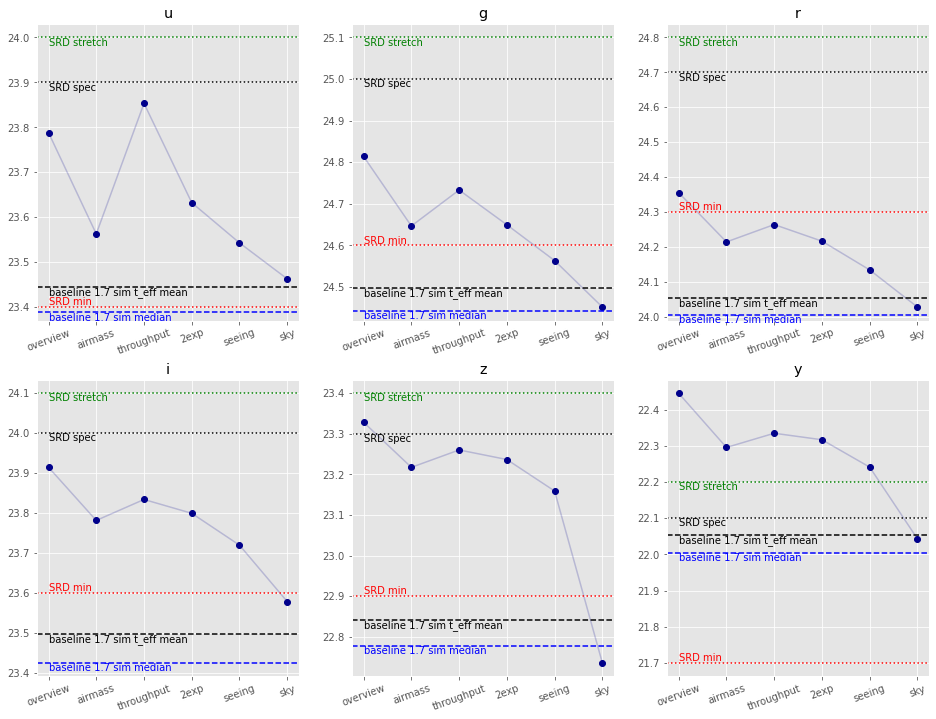

In [51]:
m5_imp = m5[['overview', 'airmass', 'throughput', '2exp', 'seeing', 'sky']].T
m5_imp.index.rename('step', inplace=True)
m5_imp.reset_index(inplace=True)
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for band, ax in zip(bands.band, axes.flatten()):
    ax.plot(m5_imp.index, m5_imp[band], marker='o', linestyle=' ', color='darkblue')
    ax.plot(m5_imp.index, m5_imp[band], alpha=0.2, color='darkblue')
    ax.set_xticks(np.arange(len(m5_imp['step'])))
    ax.set_xticklabels(m5_imp['step'], rotation=20)
    ax.set_title(band)
    ax.axhline(m5.loc[band, 'SRD spec'], linestyle=':', color='k')
    ax.text(0, m5.loc[band, 'SRD spec'], 'SRD spec', horizontalalignment='left', verticalalignment='top', color='k')
    ax.axhline(m5.loc[band, 'SRD min'], linestyle=':', color='r')
    ax.text(0, m5.loc[band, 'SRD min'], 'SRD min', horizontalalignment='left', verticalalignment='bottom', color='r')
    ax.axhline(m5.loc[band, 'SRD stretch'], linestyle=':', color='g')
    ax.text(0, m5.loc[band, 'SRD stretch'], 'SRD stretch', horizontalalignment='left', verticalalignment='top', color='g')
    ax.axhline(m5.loc[band, 'b. median'], linestyle='--', color='b')
    ax.text(0, m5.loc[band, 'b. median'], 'baseline 1.7 sim median', horizontalalignment='left', verticalalignment='top', color='b')
    ax.axhline(m5.loc[band, 'b. teff mean'], linestyle='--', color='k')
    ax.text(0, m5.loc[band, 'b. teff mean'], 'baseline 1.7 sim t_eff mean', horizontalalignment='left', verticalalignment='top', color='k')

## Examine as differences from baseline averages

In [52]:
m5.apply(lambda c: c - m5['b. teff mean'], axis=0)

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky,b. median,b. mean,b. teff mean
band,,,,,,,,,,,,
u,0.45,-0.05,0.55,0.34,0.12,0.41,0.19,0.10,0.02,-0.06,-0.09,0.00
g,0.50,0.10,0.60,0.32,0.15,0.24,0.15,0.07,-0.05,-0.06,-0.10,0.00
r,0.65,0.25,0.75,0.30,0.16,0.21,0.16,0.08,-0.03,-0.05,-0.09,0.00
i,0.50,0.10,0.60,0.42,0.28,0.34,0.30,0.22,0.08,-0.07,-0.13,0.00
z,0.46,0.06,0.56,0.49,0.38,0.42,0.39,0.32,-0.11,-0.06,-0.10,0.00
y,0.04,-0.36,0.14,0.39,0.24,0.28,0.26,0.19,-0.01,-0.05,-0.08,0.00


In [53]:
m5.apply(lambda c: c - m5['b. median'], axis=0)

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky,b. median,b. mean,b. teff mean
band,,,,,,,,,,,,
u,0.51,0.01,0.61,0.40,0.17,0.47,0.24,0.15,0.07,0.00,-0.04,0.06
g,0.56,0.16,0.66,0.37,0.20,0.29,0.21,0.12,0.01,0.00,-0.04,0.06
r,0.70,0.30,0.80,0.35,0.21,0.26,0.21,0.13,0.02,0.00,-0.04,0.05
i,0.57,0.17,0.67,0.49,0.36,0.41,0.37,0.29,0.15,0.00,-0.06,0.07
z,0.52,0.12,0.62,0.55,0.44,0.48,0.46,0.38,-0.04,0.00,-0.04,0.06
y,0.10,-0.30,0.20,0.44,0.29,0.33,0.31,0.24,0.04,0.00,-0.03,0.05


In [54]:
m5.apply(lambda c: c - m5['b. mean'], axis=0)

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky,b. median,b. mean,b. teff mean
band,,,,,,,,,,,,
u,0.55,0.05,0.65,0.44,0.21,0.50,0.28,0.19,0.11,0.04,0.00,0.09
g,0.60,0.20,0.70,0.41,0.24,0.33,0.25,0.16,0.05,0.04,0.00,0.10
r,0.74,0.34,0.84,0.39,0.25,0.30,0.25,0.17,0.06,0.04,0.00,0.09
i,0.63,0.23,0.73,0.55,0.41,0.47,0.43,0.35,0.21,0.06,0.00,0.13
z,0.56,0.16,0.66,0.59,0.48,0.52,0.50,0.42,-0.01,0.04,0.00,0.10
y,0.13,-0.27,0.23,0.47,0.32,0.36,0.35,0.27,0.07,0.03,0.00,0.08


## Find t_eff stats

In [55]:
def compute_teff_stats(*args, **kwargs):
    teff_stats = compute_teff(*args, **kwargs).groupby('band').describe().loc[bands.index].T
    return teff_stats

In [56]:
m5.apply(lambda r: compute_teff_stats(r).loc['mean'])

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky,b. median,b. mean,b. teff mean
band,,,,,,,,,,,,
u,0.43,1.09,0.36,0.53,0.81,0.47,0.71,0.84,0.97,1.11,1.19,1.00
g,0.40,0.83,0.33,0.56,0.76,0.65,0.76,0.89,1.09,1.11,1.19,1.00
r,0.30,0.64,0.25,0.57,0.75,0.68,0.74,0.86,1.05,1.10,1.18,1.00
i,0.40,0.83,0.33,0.46,0.59,0.54,0.57,0.66,0.86,1.14,1.27,1.00
z,0.43,0.90,0.36,0.41,0.50,0.46,0.48,0.56,1.22,1.12,1.20,1.00
y,0.92,1.92,0.77,0.49,0.64,0.60,0.62,0.71,1.02,1.10,1.17,1.00


In [57]:
m5.apply(lambda r: compute_teff_stats(r).loc['50%'])

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky,b. median,b. mean,b. teff mean
band,,,,,,,,,,,,
u,0.39,0.98,0.32,0.48,0.72,0.42,0.64,0.75,0.87,1.00,1.07,0.90
g,0.36,0.75,0.30,0.50,0.69,0.59,0.68,0.80,0.98,1.00,1.07,0.90
r,0.28,0.58,0.23,0.52,0.68,0.62,0.68,0.79,0.96,1.00,1.07,0.91
i,0.35,0.73,0.29,0.41,0.52,0.47,0.50,0.58,0.75,1.00,1.11,0.88
z,0.38,0.80,0.32,0.36,0.45,0.41,0.43,0.50,1.08,1.00,1.07,0.89
y,0.84,1.75,0.70,0.44,0.58,0.54,0.56,0.65,0.93,1.00,1.06,0.91


## Progression table

In [58]:
m5

,SRD spec,SRD min,SRD stretch,overview,airmass,throughput,2exp,seeing,sky,b. median,b. mean,b. teff mean
band,,,,,,,,,,,,
u,23.90,23.40,24.00,23.79,23.56,23.85,23.63,23.54,23.46,23.39,23.35,23.45
g,25.00,24.60,25.10,24.81,24.65,24.73,24.65,24.56,24.45,24.44,24.40,24.50
r,24.70,24.30,24.80,24.36,24.21,24.26,24.22,24.13,24.03,24.00,23.96,24.05
i,24.00,23.60,24.10,23.92,23.78,23.83,23.80,23.72,23.58,23.43,23.37,23.50
z,23.30,22.90,23.40,23.33,23.22,23.26,23.24,23.16,22.74,22.78,22.74,22.84
y,22.10,21.70,22.20,22.45,22.30,22.34,22.32,22.24,22.04,22.00,21.97,22.06


In [59]:
m5prog = m5[['overview']].copy()

m5prog['throughput'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'], r['m_sky'], overview_table2['theta_eff'][r['band']], expTime=15, airmass=1, nexp=2), axis=1).values
m5prog['seeing'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'], r['m_sky'],
                              pd.Series(seeing_model(seeing500, 1.0)['fwhmEff'], index=bands.index)[r['band']],
                              expTime=15, airmass=1, nexp=2), axis=1).values
m5prog['sky'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              dark_sky_mags[r['band']].median(),
                              pd.Series(seeing_model(seeing500, 1.0)['fwhmEff'], index=bands.index)[r['band']],
                              expTime=15, airmass=1, nexp=2), axis=1).values
m5prog['X_k'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              dark_sky_mags[r['band']].median(),
                              pd.Series(seeing_model(seeing500, 1.0)['fwhmEff'], index=bands.index)[r['band']],
                              expTime=15, airmass=1.2, nexp=2), axis=1).values
m5prog['X_seeing'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              dark_sky_mags[r['band']].median(),
                              pd.Series(seeing_model(seeing500, 1.2)['fwhmEff'], index=bands.index)[r['band']],
                              expTime=15, airmass=1.2, nexp=2), axis=1).values
m5prog['X'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              sky_x12_mag_stats.loc['75%', r['band']],
                              pd.Series(seeing_model(seeing500, 1.2)['fwhmEff'], index=bands.index)[r['band']],
                              expTime=15, airmass=1.2, nexp=2), axis=1).values
m5prog['moon'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              typical_m_sky[r['band']],
                              pd.Series(seeing_model(seeing500, 1.2)['fwhmEff'], index=bands.index)[r['band']],
                              expTime=15, airmass=1.2, nexp=2), axis=1).values
print(m5prog)

      overview  throughput  seeing   sky   X_k  X_seeing     X  moon
band                                                                
u        23.79       23.86   23.76 23.71 23.61     23.49 23.46 23.46
g        24.81       24.82   24.73 24.67 24.63     24.51 24.45 24.45
r        24.36       24.36   24.28 24.24 24.22     24.10 24.03 24.03
i        23.92       23.93   23.86 23.82 23.80     23.68 23.60 23.58
z        23.33       23.35   23.29 23.21 23.20     23.08 23.00 22.74
y        22.45       22.47   22.39 22.40 22.37     22.25 22.16 22.04


In [60]:
print(m5.loc[:, ['b. median', 'b. mean']].apply(lambda x: x - m5prog.moon).rename(columns={'b. median': 'sim median - model', 'b. mean': 'sim mean - model'}))

      sim median - model  sim mean - model
band                                      
u                  -0.07             -0.11
g                  -0.01             -0.05
r                  -0.02             -0.06
i                  -0.15             -0.21
z                   0.04              0.01
y                  -0.04             -0.07


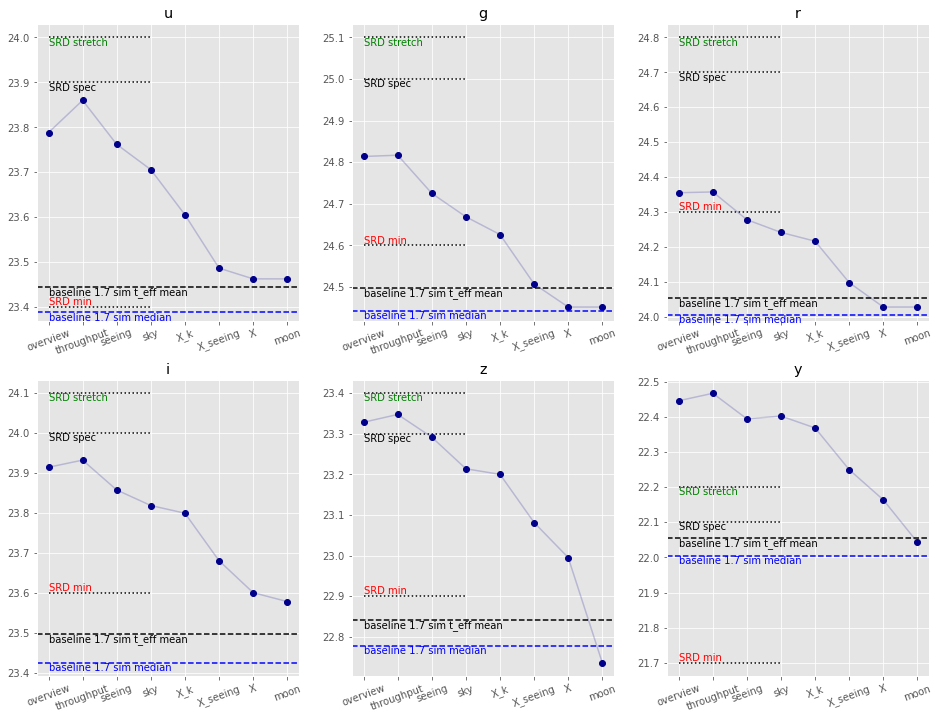

In [61]:
m5p_imp = m5prog.T
m5p_imp.index.rename('step', inplace=True)
m5p_imp.reset_index(inplace=True)
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for band, ax in zip(bands.band, axes.flatten()):
    ax.plot(m5p_imp.index, m5p_imp[band], marker='o', linestyle=' ', color='darkblue')
    ax.plot(m5p_imp.index, m5p_imp[band], alpha=0.2, color='darkblue')
    ax.set_xticks(np.arange(len(m5p_imp['step'])))
    ax.set_xticklabels(m5p_imp['step'], rotation=20)
    ax.set_title(band)
    ax.hlines(m5.loc[band, ['SRD spec', 'SRD min', 'SRD stretch']], xmin=0, xmax=3, linestyle=':', color='k')
    ax.text(0, m5.loc[band, 'SRD spec'], 'SRD spec', horizontalalignment='left', verticalalignment='top', color='k')
    ax.text(0, m5.loc[band, 'SRD min'], 'SRD min', horizontalalignment='left', verticalalignment='bottom', color='r')
    ax.text(0, m5.loc[band, 'SRD stretch'], 'SRD stretch', horizontalalignment='left', verticalalignment='top', color='g')
    ax.axhline(m5.loc[band, 'b. median'], linestyle='--', color='b')
    ax.text(0, m5.loc[band, 'b. median'], 'baseline 1.7 sim median', horizontalalignment='left', verticalalignment='top', color='b')
    ax.axhline(m5.loc[band, 'b. teff mean'], linestyle='--', color='k')
    ax.text(0, m5.loc[band, 'b. teff mean'], 'baseline 1.7 sim t_eff mean', horizontalalignment='left', verticalalignment='top', color='k')

## Using median airmass, seeing, sky brightness of baseline visits

In [62]:
m5visits = m5prog[['overview', 'throughput', 'seeing', 'sky']].copy()
m5visits['sim_X'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              dark_sky_mags[r['band']].median(),
                              pd.Series(seeing_model(seeing500, 1.0)['fwhmEff'], index=bands.index)[r['band']],
                              expTime=15, airmass=visits.loc[visits['filter']==r['band'],'airmass'].median(), nexp=2), axis=1).values
m5visits['sim_seeing'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              dark_sky_mags[r['band']].median(),
                              visits.loc[visits['filter']==r['band'], 'seeingFwhmEff'].median(),
                              expTime=15, airmass=visits.loc[visits['filter']==r['band'], 'airmass'].median(), nexp=2), axis=1).values
m5visits['sim_sky'] = overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              visits.loc[visits['filter']==r['band'], 'skyBrightness'].median(),
                              visits.loc[visits['filter']==r['band'], 'seeingFwhmEff'].median(),
                              expTime=15, airmass=visits.loc[visits['filter']==r['band'],'airmass'].median(), nexp=2), axis=1).values
print(m5visits)

step  overview  throughput  seeing   sky  sim_X  sim_seeing  sim_sky
band                                                                
u        23.79       23.86   23.76 23.71  23.65       23.52    23.51
g        24.81       24.82   24.73 24.67  24.64       24.51    24.48
r        24.36       24.36   24.28 24.24  24.23       24.10    24.04
i        23.92       23.93   23.86 23.82  23.81       23.67    23.54
z        23.33       23.35   23.29 23.21  23.21       23.07    22.83
y        22.45       22.47   22.39 22.40  22.38       22.24    22.04


In [63]:
print(m5.loc[:, ['b. median', 'b. mean']].apply(lambda x: x - m5visits.sim_sky).rename(columns={'b. median': 'sim median - model', 'b. mean': 'sim mean - model'}))

      sim median - model  sim mean - model
band                                      
u                  -0.12             -0.16
g                  -0.03             -0.07
r                  -0.04             -0.08
i                  -0.12             -0.17
z                  -0.05             -0.08
y                  -0.04             -0.07


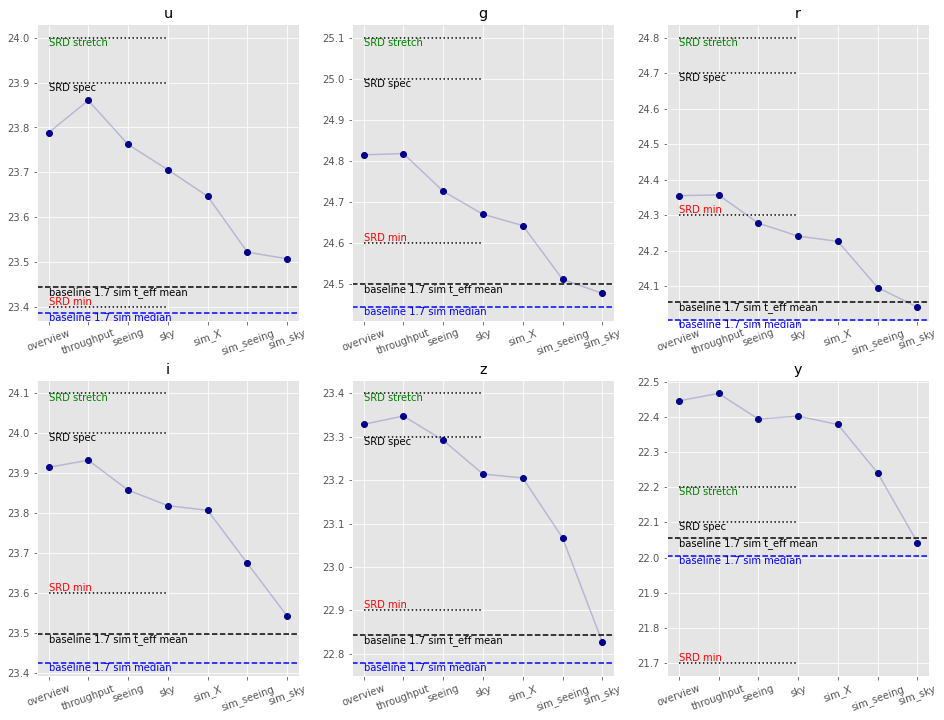

In [64]:
m5p_imp = m5visits.T
m5p_imp.index.rename('step', inplace=True)
m5p_imp.reset_index(inplace=True)
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for band, ax in zip(bands.band, axes.flatten()):
    ax.plot(m5p_imp.index, m5p_imp[band], marker='o', linestyle=' ', color='darkblue')
    ax.plot(m5p_imp.index, m5p_imp[band], alpha=0.2, color='darkblue')
    ax.set_xticks(np.arange(len(m5p_imp['step'])))
    ax.set_xticklabels(m5p_imp['step'], rotation=20)
    ax.set_title(band)
    ax.hlines(m5.loc[band, ['SRD spec', 'SRD min', 'SRD stretch']], xmin=0, xmax=3, linestyle=':', color='k')
    ax.text(0, m5.loc[band, 'SRD spec'], 'SRD spec', horizontalalignment='left', verticalalignment='top', color='k')
    ax.text(0, m5.loc[band, 'SRD min'], 'SRD min', horizontalalignment='left', verticalalignment='bottom', color='r')
    ax.text(0, m5.loc[band, 'SRD stretch'], 'SRD stretch', horizontalalignment='left', verticalalignment='top', color='g')
    ax.axhline(m5.loc[band, 'b. median'], linestyle='--', color='b')
    ax.text(0, m5.loc[band, 'b. median'], 'baseline 1.7 sim median', horizontalalignment='left', verticalalignment='top', color='b')
    ax.axhline(m5.loc[band, 'b. teff mean'], linestyle='--', color='k')
    ax.text(0, m5.loc[band, 'b. teff mean'], 'baseline 1.7 sim t_eff mean', horizontalalignment='left', verticalalignment='top', color='k')

## Sky brightness and moon

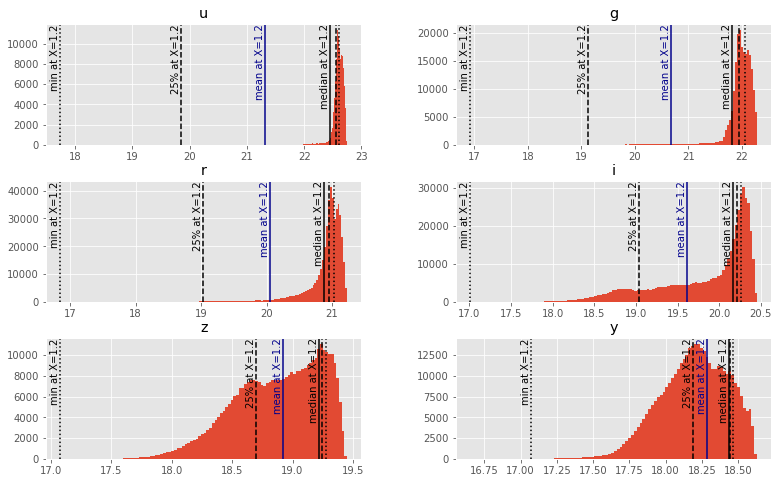

In [65]:
fig, axes = plt.subplots(3, 2, figsize=(13, 8))
for band, ax in zip(bands.band, axes.flatten()):
    visits.query(f"band == '{band}'").hist('skyBrightness', bins=100, ax=ax)
    text_trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
    ax.axvline(sky_x12_mag_stats.loc['mean', band], color='darkblue')
    ax.text(sky_x12_mag_stats.loc['mean', band], 1, 'mean at X=1.2', transform=text_trans, horizontalalignment='right', verticalalignment='top', rotation=90, color='darkblue')

    ax.axvline(sky_x12_mag_stats.loc['min', band], color='black', linestyle=":")
    ax.text(sky_x12_mag_stats.loc['min', band], 1, 'min at X=1.2', transform=text_trans, horizontalalignment='right', verticalalignment='top', rotation=90, color='black')
    ax.axvline(sky_x12_mag_stats.loc['max', band], color='black', linestyle=":")
    
    ax.axvline(sky_x12_mag_stats.loc['25%', band], color='black', linestyle='--')
    ax.text(sky_x12_mag_stats.loc['25%', band], 1, '25% at X=1.2', transform=text_trans, horizontalalignment='right', verticalalignment='top', rotation=90, color='black')
    ax.axvline(sky_x12_mag_stats.loc['75%', band], color='black', linestyle='--')

    ax.axvline(sky_x12_mag_stats.loc['50%', band], color='black')
    ax.text(sky_x12_mag_stats.loc['50%', band], 1, 'median at X=1.2', transform=text_trans, horizontalalignment='right', verticalalignment='top', rotation=90, color='black')

    ax.set_title(band)

In [66]:
sky_mags_x12.describe()

,u,g,r,i,z,y,mjd
count,146227.00,146227.00,146227.00,146227.00,146227.00,146227.00,148164.00
mean,21.32,20.68,20.05,19.61,18.92,18.28,61691.99
std,1.57,1.62,1.20,0.84,0.48,0.26,1054.35
min,17.75,16.93,16.85,17.01,17.08,17.07,59854.00
25%,19.85,19.13,19.04,19.03,18.70,18.19,60788.37
50%,22.45,21.83,20.87,20.16,19.22,18.43,61680.17
75%,22.56,21.96,20.95,20.21,19.25,18.44,62615.11
max,22.61,22.07,21.03,20.26,19.28,18.47,63506.39


## Checking parameters from sims_utils

In [67]:
sims_utils_params = pd.DataFrame({'C_m': m5_flat_sed.Cm,
                                  'Delta_C_m_infinity': m5_flat_sed.dCm_infinity})
param_compare = pd.concat([overview_table2[sims_utils_params.columns], sims_utils_params], keys=['overview table 2', 'sims_utils'], axis=1).reorder_levels((1,0), axis=1)
param_compare = param_compare.reindex(sorted(param_compare.columns), axis=1)
print(param_compare)

               C_m            Delta_C_m_infinity           
  overview table 2 sims_utils   overview table 2 sims_utils
u            23.09      23.39               0.62       0.37
g            24.42      24.51               0.18       0.10
r            24.44      24.49               0.10       0.05
i            24.32      24.37               0.07       0.04
z            24.16      24.20               0.05       0.02
y            23.73      23.77               0.04       0.02


## Coadd-depth based $t_{\mbox{eff}}$

In [68]:
coadd_depth = pd.DataFrame({'mag': [26.1, 27.4, 27.5, 26.8, 26.1, 24.9],
                            'visits': [56, 80, 184, 184, 160, 160]}, index=bands.band).reindex(visits.index)
coadd_depth['m0'] = coadd_depth.mag - 1.25*np.log10(coadd_depth.visits)
coadd_depth['prog'] = m5prog.moon
coadd_depth['round'] = np.round(m5prog.sky*2)/2
coadd_depth['m0_visit_teff'] = (10**(0.8*(visits.fiveSigmaDepth - coadd_depth.m0))).groupby('band').mean()
coadd_depth['prog_visit_teff'] = (10**(0.8*(visits.fiveSigmaDepth - coadd_depth.prog))).groupby('band').mean()
coadd_depth['round_visit_teff'] = (10**(0.8*(visits.fiveSigmaDepth - coadd_depth['round']))).groupby('band').mean()
coadd_depth.groupby('band').first().loc[bands.band]

,mag,visits,m0,prog,round,m0_visit_teff,prog_visit_teff,round_visit_teff
band,,,,,,,,
u,26.10,56,23.91,23.46,23.50,0.42,0.97,0.90
g,27.40,80,25.02,24.45,24.50,0.38,1.09,1.00
r,27.50,184,24.67,24.03,24.00,0.32,1.05,1.11
i,26.80,184,23.97,23.58,24.00,0.42,0.86,0.40
z,26.10,160,23.34,22.74,23.00,0.40,1.22,0.75
y,24.90,160,22.14,22.04,22.50,0.85,1.02,0.44


## Best possible as reference for $t_{\mbox{eff}}$

In [69]:
overview_table2.reset_index().apply(
        lambda r: m5_flat_sed(r['band'],
                              dark_sky_mags[r['band']].max(),
                              pd.Series(seeing_model(0.0, 1.0)['fwhmEff'], index=bands.index)[r['band']],
                              expTime=15, airmass=1, nexp=2), axis=1)

0   24.56
1   25.51
2   25.01
3   24.52
4   23.87
5   23.02
dtype: float64

In [70]:
best_m5 = pd.DataFrame({
    'm5': overview_table2.reset_index().apply(lambda r: m5_flat_sed(r['band'],
                                                                    dark_sky_mags[r['band']].max(),
                                                                    pd.Series(seeing_model(0.0, 1.0)['fwhmEff'], index=bands.index)[r['band']],
                                                                    expTime=15, airmass=1, nexp=2), axis=1).values},
    index=bands.band)
best_m5['round_best'] = np.round(best_m5.m5*2)/2
best_m5['m5 mean teff'] = 30*(10**(0.8*(visits.fiveSigmaDepth - best_m5.reindex(visits.index).m5))).groupby('band').mean()
best_m5['round mean teff'] = 30*(10**(0.8*(visits.fiveSigmaDepth - best_m5.reindex(visits.index).round_best))).groupby('band').mean()
best_m5

,m5,round_best,m5 mean teff,round mean teff
band,,,,
u,24.56,24.50,3.81,4.30
g,25.51,25.50,4.63,4.74
r,25.01,25.00,5.19,5.26
i,24.52,24.50,4.56,4.74
z,23.87,24.00,4.55,3.55
y,23.02,23.00,5.06,5.26


### Distributions of t_eff in units of ideal visits, unrounded reference points

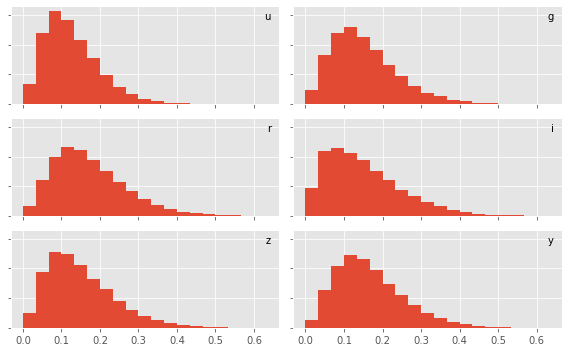

In [71]:
teff = (10**(0.8*(visits.fiveSigmaDepth - best_m5.reindex(visits.index).m5)))
fig, axes = plt.subplots(3,2, sharex=True, sharey=True)
for band, ax in zip(bands.band, axes.flatten()):
    teff[band].hist(bins=np.arange(20)/30, ax=ax, density=True)
    ax.text(0.97, 0.95, band, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.set_yticklabels([])
plt.tight_layout()

### Distributions in units of ideal seconds, unrounded reference points

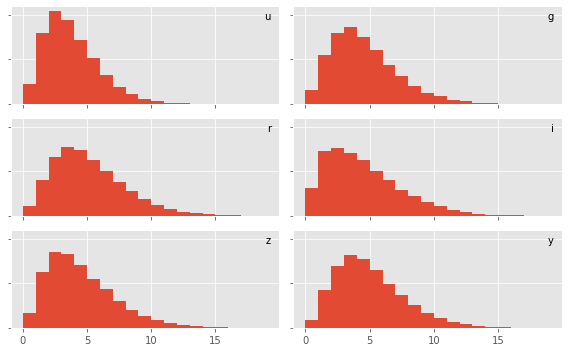

In [72]:
teff = 30*(10**(0.8*(visits.fiveSigmaDepth - best_m5.reindex(visits.index).m5)))
fig, axes = plt.subplots(3,2, sharex=True, sharey=True)
for band, ax in zip(bands.band, axes.flatten()):
    teff[band].hist(bins=np.arange(20), ax=ax, density=True)
    ax.text(0.97, 0.95, band, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.set_yticklabels([])
plt.tight_layout()

### Distributions in unites of ideal seconds, rounded reference points

In [73]:
round_teff = 30*(10**(0.8*(visits.fiveSigmaDepth - best_m5.reindex(visits.index).round_best)))

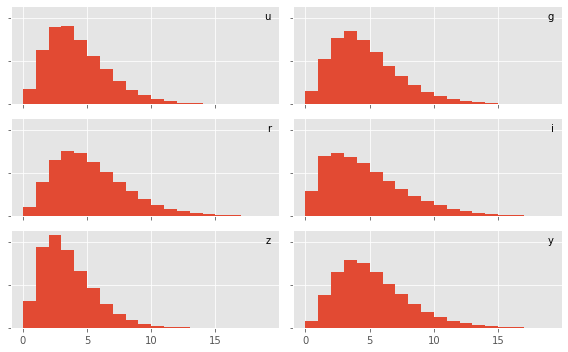

In [74]:
fig, axes = plt.subplots(3,2, sharex=True, sharey=True)
for band, ax in zip(bands.band, axes.flatten()):
    round_teff[band].hist(bins=np.arange(20), ax=ax, density=True)
    ax.text(0.97, 0.95, band, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.set_yticklabels([])
plt.tight_layout()